# Applying MCMC on CO2 data

We take again the CO2 problem, and now try to do better with EMCEE...

In [3]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import pandas as pd
import scipy, emcee, corner, uncertainties
from scipy.optimize import curve_fit

# We fix the random seed to always get the same problem

np.random.seed(seed=42)

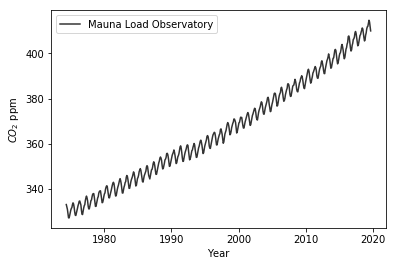

In [4]:
import pandas as pd # we need the pandas library, really useful to read excel, csv files, etc...
dat = pd.read_table('CO2_noaa_01102019.csv',
                  comment='#', sep='\s+', header=None, na_values=[-1, -99.99])

# what are the columns? 
dat.columns = ['year', 'month', 'dec_year', 'co2_av', 'co2_interp', 'co2_trend', 'days']

# let's make sure there is no NAN (missign values, happens in various geochemical records!)
dat.dropna(inplace=True)  # necessary because optimisation fails if there are NaNs in the data

# let's plot those data
plt.plot(dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'], c=(0,0,0,0.8), label='Mauna Load Observatory')

plt.xlabel('Year')
plt.ylabel('$CO_2$ ppm')

plt.legend()

# This is the forward model

$d = g(m)$

In [5]:
def forward_model(time, p0, p1, p2, p3, phase, amp):
    seasonal = np.sin((time - phase) * (2 * np.pi)) * amp
    return time**3 * p3 + time**2 * p2 + time * p1 + p0 + seasonal

# Last time we tried fitting with curve_fit

A crude error propagation was done with using the diagonal of the covariance matrix calculated by curve_fit.

Results are... Not great.

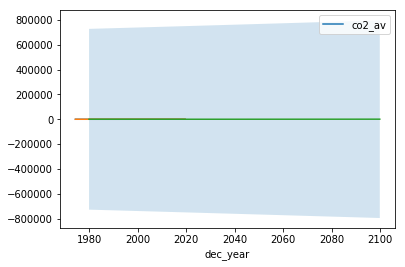

In [6]:
x = dat.loc[:, 'dec_year']
y = dat.loc[:, 'co2_av'].values
yerr = 0.001*y
 
p, cov = curve_fit(forward_model, dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'], sigma = yerr)

ax = dat.plot('dec_year', 'co2_av')

ax.plot(dat.loc[:, 'dec_year'], forward_model(dat.loc[:, 'dec_year'], *p))

# loading the library
from uncertainties import unumpy as un

# we define an uncertainties array of the parameters 
# and their variance/covariance (see uncertainties documentation)
params = un.uarray(p, np.sqrt(np.diag(cov)))

# we redefine our function to work with unumpy
def co2_record_unumpy(time, p0, p1, p2, p3, phase, amp):
    seasonal = un.sin((time - phase) * (2 * np.pi)) * amp
    return time**3 * p3 + time**2 * p2 + time * p1 + p0 + seasonal

# new time step
time = np.arange(1980, 2100, 0.1)
pred = co2_record_unumpy(time, *params)

plt.plot(time, un.nominal_values(pred))

plt.fill_between(time, un.nominal_values(pred) - un.std_devs(pred),
                 un.nominal_values(pred) + un.std_devs(pred), alpha=0.2, zorder=-1)

# Defining the PPD as the sum of the log likelyhood and the log prior

Remember, the Posterior Probability Density of our model is the sum of its log likelyhood and its log prior.

In [7]:
def llf(p,mu,sigma):
    """gaussian distribution (log form)"""
    return -0.5*np.sum((p-mu)**2/sigma**2 + np.log(2*np.pi*sigma**2))

def logprior(theta):
    """log prior probability function for the parameters
    
    This implementation uses a uniform distribution
    
    Parameters
    ==========
    theta : list
        the parameters
        
    Returns
    =======
    logprob_prior : the estimated probability of the prior values
    
    """
    p0, p1, p2, p3, phase, amp = theta
    
    return 0.0
    
def loglike(theta,x,y,yerr):
    """log likelyhood function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
        
    Returns
    =======
    ln_likely : float
        the estimated likelyhood of the a model compared to observations
    
    """
    p0, p1, p2, p3, phase, amp = theta
    model = forward_model(x, p0, p1, p2, p3, phase, amp)
    ln_likely = llf(model,y,yerr)
    return ln_likely

def logjoint(theta, x, y, yerr):
    """joint probability function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
        
    Returns
    =======
    ln_prob : float
        the total likelyhood of a model compared to observations
    
    """
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta,x,y,yerr)

# Sampling the PPD with EMCEE

See their documentation, it's awesome!

In [9]:
# We start at the best value found by curve_fit
theta_prior = p

# Set up the sampler.
ndim, nwalkers = len(theta_prior), 100
pos = [p + p*1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, logjoint, args=(x, y, yerr))

# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, 5000, rstate0=np.random.get_state())
print("Done.")

Running MCMC...
Done.


# Looking at the variability of each parameter as a function of iterations

Stable scattering of the walkers is good: it is a good sign of convergence, i.e. the algorithm sampled a good portion of the parameter space and its mean converged to the global optimal values.

Assessing convergence of MCMC algorithms is an art, outside of the scope of this introduction. I advise looking at (1) the documentation of EMCEE for instance, (2) litterature and books on this subject.

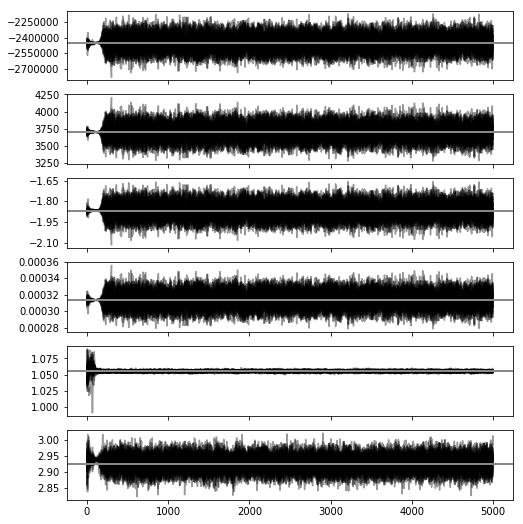

In [12]:
from matplotlib.ticker import MaxNLocator
plt.clf()
fig, axes = plt.subplots(p.size, 1, sharex=True, figsize=(8, 9))

for i in range(p.size):
    axes[i].plot(sampler.chain[0:50:, :, i].T, color="k", alpha=0.4)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].axhline(p[i], color="#888888", lw=2)
    #axes[0].set_ylabel("$m$")


# Looking at covariance of parameters

Using the package 'corner', we can look at how each parameter depends on the other. In those contour plots, each model is plotted, such that a high density of models result in a dark color, indicating a higher probability.

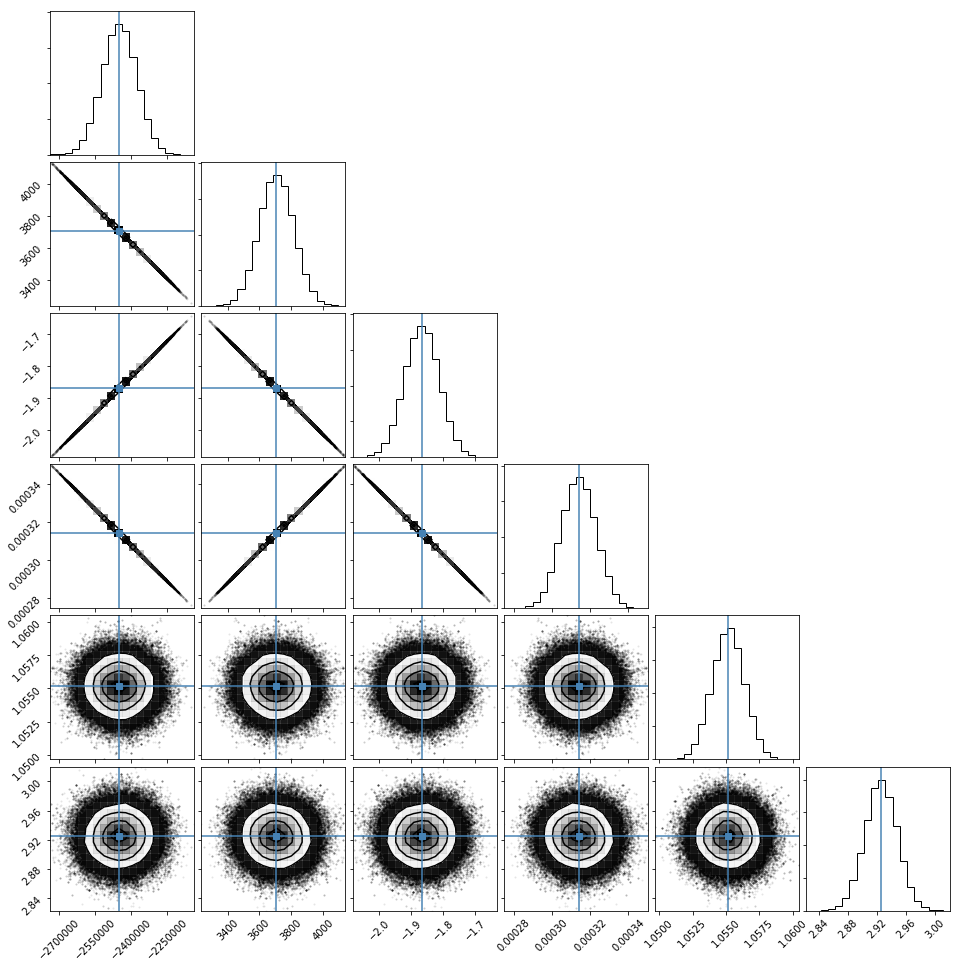

In [15]:
# Make the triangle plot.
burnin = 500
samples = sampler.chain[:, burnin:-1, :].reshape((-1, ndim))

fig = corner.corner(samples,
                      truths=p)

# Mean and standard deviation of the parameters

As the individual distribution of each parameter is close to a Gaussian, the mean and standard deviation for each parameters should be good.

In [18]:
p_mcmc = np.mean(samples,0)
p_mcmc_std = np.std(samples,0)
print("The mean values are {}".format(p_mcmc))
print("The standard deviations of parameters are {}".format(p_mcmc))

The mean values are [-2.45083088e+06  3.70531347e+03 -1.86779092e+00  3.13967084e-04
  1.05515638e+00  2.92530365e+00]
The standard deviations of parameters are [-2.45083088e+06  3.70531347e+03 -1.86779092e+00  3.13967084e-04
  1.05515638e+00  2.92530365e+00]


# Now we can look at a thousand sampled models.

Remember: we do not want a "best" model, but we want to build our knowledge based on a sample of probable models.

We also take the chance to improve the propagation of errors from the curve_fit modeling by using the full covariance matrix during the propagation.

In [21]:
# Looking at possible models on the x timescale of the data
possible_models_x = np.ones((len(x),1000))
for i in range(1000):
    possible_models_x[:,i] = forward_model(x,*samples[i,:])
    
# Extrapolation to year 2100
time = np.arange(1980, 2100, 0.1)
    
possible_models_extrapol = np.ones((len(time),1000))
for i in range(1000):
    possible_models_extrapol[:,i] = forward_model(time,*samples[i,:])

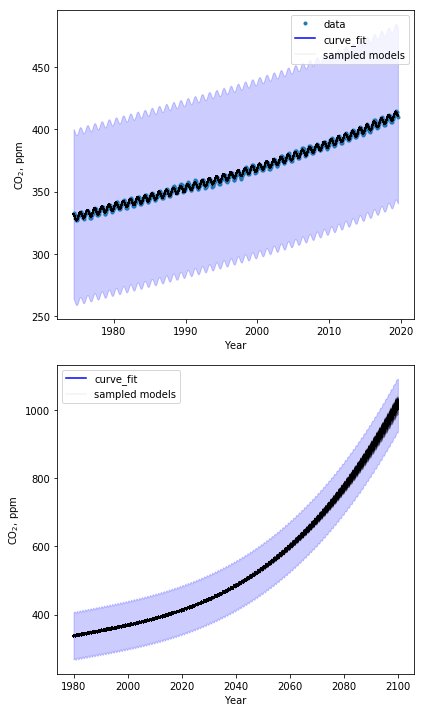

In [22]:
fig = plt.figure(figsize=(6,10))

ax = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

# we define an uncertainties array of the parameters 
# and their variance/covariance (see uncertainties documentation)
params = uncertainties.correlated_values(p, cov)

# we redefine our function to work with unumpy
def co2_record_unumpy(time, p0, p1, p2, p3, phase, amp):
    seasonal = un.sin((time - phase) * (2 * np.pi)) * amp
    return time**3 * p3 + time**2 * p2 + time * p1 + p0 + seasonal

# First subplot: Fitted data
ax.plot(x, y,".",label="data")
pred = co2_record_unumpy(x, *params)
ax.plot(x, un.nominal_values(pred),color="blue",label="curve_fit")

ax.fill_between(x, un.nominal_values(pred) - un.std_devs(pred),
                 un.nominal_values(pred) + un.std_devs(pred), color="blue", alpha=0.2, zorder=-1)

ax.plot(x,possible_models_x[:,0],"k",alpha=0.05,label="sampled models")
ax.legend()
ax.plot(x,possible_models_x,"k",alpha=0.05)

ax.set_xlabel("Year")
ax.set_ylabel("CO$_2$, ppm")

# Second subplot: extrapolation
# new time step

pred_extra = co2_record_unumpy(time, *params)
ax2.plot(time, un.nominal_values(pred_extra),color="blue",label="curve_fit")

ax2.fill_between(time, un.nominal_values(pred_extra) - un.std_devs(pred_extra),
                 un.nominal_values(pred_extra) + un.std_devs(pred_extra), alpha=0.2, color="blue", zorder=-1)

ax2.plot(time,possible_models_extrapol[:,0],"k",alpha=0.05,label="sampled models")
ax2.legend()
ax2.plot(time,possible_models_extrapol,"k",alpha=0.05)

ax2.set_xlabel("Year")
ax2.set_ylabel("CO$_2$, ppm")

plt.tight_layout()

# Conclusion notes: comparison of least-squares and MCMC

We see that despite improving error propagation with curve_fit, we still do reach the precision of the MCMC approach.

Better sampling of the model space is obtained by using MCMC, and, as a consequence, we know much more about the errors on the model parameters as well as on the model predictions.